# What's your beer style?

This dataset contains tasting profiles and consumer reviews for 403 unique beers from 281 different breweries. It was created by integrating information from two existing data sets on Kaggle: Beer Tasting Profiles Dataset and 1.5 Million Beer Reviews.

## Columns

- ID: A unique ID that identifies the beer
- Name: Beer name
- Brewery: Brewery name
- Beer Name (Full): Complete beer name (Brewery + Brew Name)
- Description: Notes on the beer if available
- ABV: Alcohol content of beer (% by volume)
- Min IBU: The minimum IBU value each beer can possess
- Max IBU: The maximum IBU value each beer can possess

The next eleven columns represent taste and aroma descriptors taken from up to 25 reviews of each beer.
- Astringency
- Body
- Alcohol
- Bitter
- Sweet
- Sour
- Salty
- Fruits
- Hoppy
- Spices
- Malty

The last six columns refer to information regarding beer reviews:
- review _ aroma: The average rating for aroma
- review _ appearance: The average rating for appearance
- review _ palate: The average rating for mouthfeel
- review _ taste: The average rating for taste
- review _ overall: The overall average rating of the beer
- number _ of _ reviews: The number of reviews taken into consideration

In [254]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

for dirname, _, filenames in os.walk("/kaggle/input"):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ml-olympiad-can-you-guess-beer-style/sample_submission.csv
/kaggle/input/ml-olympiad-can-you-guess-beer-style/train.csv
/kaggle/input/ml-olympiad-can-you-guess-beer-style/test.csv


In [255]:
import os

In [282]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List
import gc
from sklearn.metrics import f1_score


from tqdm.auto import tqdm
import math
from sklearn.model_selection import (
    KFold,
    StratifiedKFold,
    train_test_split,
    GridSearchCV,
)
import warnings

warnings.filterwarnings("ignore")

import plotly.express as px

import lightgbm as lgb

In [257]:
def load_data(prefix: str, file_name: str) -> pd.core.frame.DataFrame:
    return pd.read_csv(os.path.join(prefix, file_name))

In [ ]:
prefix = "/kaggle/input/ml-olympiad-can-you-guess-beer-style"

In [258]:
train_df = load_data(prefix, "train.csv")
test_df = load_data(prefix, "test.csv")
submission_df = load_data(prefix, "sample_submission.csv")

# Exploratory Data Analysis

### Data Summary

In [259]:
train_df.shape

(518, 26)

In [260]:
train_df.head()

,ID,Name,Brewery,Beer Name (Full),Description,ABV,Min IBU,Max IBU,Astringency,Body,...,Hoppy,Spices,Malty,review_aroma,review_appearance,review_palate,review_taste,review_overall,number_of_reviews,Style
0,282,Original,Jacob Leinenkugel Brewing Company,Jacob Leinenkugel Brewing Company Leinenkugel'...,Notes:,4.6,8.0,18.0,17.0,28.0,...,42.0,3.0,43.0,2.742424,3.060606,2.960606,2.978788,3.275758,165.0,6
1,183,Lucifer,Brouwerij Het Anker,Brouwerij Het Anker Lucifer,Notes:,8.0,20.0,NaN,10.0,24.0,...,9876.0,15.0,31.0,3.776119,4.029851,3.768657,3.791045,3.843284,67.0,0
2,139,Victor Ale,Allagash Brewing Company,Allagash Brewing Company Allagash Victor Ale,Notes:The Victor Ale was inspired by its femin...,9.0,20.0,9876.0,24.0,35.0,...,26.0,15.0,39.0,3.865079,3.924603,3.960317,3.884921,3.813492,126.0,0
3,179,Budweiser,Anheuser-Busch,Anheuser-Busch Budweiser,Notes:Brewed using a blend of imported and cla...,5.0,8.0,18.0,6.0,17.0,...,15.0,3.0,50.0,2.189644,2.516476,2.473100,2.420309,2.883995,1487.0,6
4,463,Pilsener,Browerij Nacional Balashi,Browerij Nacional Balashi Balashi,Notes:The beer has a deep golden color totally...,5.0,18.0,25.0,26.0,23.0,...,21.0,1.0,50.0,2.634921,2.976190,3.055556,2.952381,3.333333,63.0,1


In [261]:
train_df.describe().style.background_gradient(cmap="Pastel1")

,ID,ABV,Min IBU,Max IBU,Astringency,Body,Alcohol,Bitter,Sweet,Sour,Salty,Fruits,Hoppy,Spices,Malty,review_aroma,review_appearance,review_palate,review_taste,review_overall,number_of_reviews,Style
count,518.000000,491.000000,492.000000,491.000000,494.000000,494.000000,492.000000,493.000000,492.000000,493.000000,490.000000,492.000000,491.000000,494.000000,493.000000,491.000000,495.000000,492.000000,492.000000,490.000000,493.000000,518.000000
mean,386.650579,106.686334,140.089431,153.853360,116.785425,146.493927,135.310976,112.340771,159.048780,154.391481,81.548980,140.802846,137.002037,118.757085,191.933063,124.238577,123.406949,124.027242,104.012808,104.481400,386.513185,7.073359
std,165.405169,991.914855,1082.901178,1082.546306,987.888070,985.166169,1083.499726,884.264548,986.138288,1080.754433,889.480110,988.004659,989.182597,987.874809,1076.657033,1085.751846,1081.385285,1084.655468,991.163427,993.161424,1110.931279,4.766747
min,100.000000,2.500000,8.000000,15.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.901070,2.131016,2.079137,1.500000,2.000000,1.000000,0.000000
25%,243.250000,5.000000,15.000000,23.000000,10.000000,29.000000,6.000000,15.000000,33.000000,11.000000,0.000000,12.000000,17.000000,5.000000,45.000000,3.437350,3.627206,3.442570,3.500000,3.554616,53.000000,3.000000
50%,388.500000,5.500000,20.000000,35.000000,15.000000,41.000000,10.000000,26.000000,56.000000,26.000000,0.000000,32.000000,30.000000,12.000000,71.000000,3.714286,3.858124,3.741060,3.789324,3.832650,156.000000,6.000000
75%,530.750000,7.450000,25.000000,40.000000,22.000000,58.000000,20.000000,49.000000,79.250000,44.000000,1.000000,67.000000,51.000000,27.000000,98.000000,3.956244,4.014711,3.950210,4.016385,4.007251,363.000000,11.000000
max,675.000000,9876.000000,9876.000000,9876.000000,9876.000000,9876.000000,9876.000000,9876.000000,9876.000000,9876.000000,9876.000000,9876.000000,9876.000000,9876.000000,9876.000000,9876.000000,9876.000000,9876.000000,9876.000000,9876.000000,9876.000000,16.000000


In [283]:
def get_summary(df: pd.core.frame.DataFrame) -> pd.core.frame.DataFrame:
    summary = pd.DataFrame(df.dtypes, columns=["data_type"])
    summary["total_missing"] = df.isnull().sum().values * 100
    summary["percentage_missing"] = df.isnull().sum().values / len(df)
    summary["total_unique"] = df.nunique().values
    desc = pd.DataFrame(df.describe(include="all").transpose())
    summary["min"] = desc["min"].values
    summary["max"] = desc["max"].values

    return summary.style.background_gradient(cmap="Pastel1")

In [263]:
get_summary(train_df)

,data_type,total_missing,percentage_missing,total_unique,min,max
ID,int64,0,0.000000,518,100.000000,675.000000
Name,object,0,0.000000,497,nan,nan
Brewery,object,0,0.000000,326,nan,nan
Beer Name (Full),object,0,0.000000,518,nan,nan
Description,object,0,0.000000,295,nan,nan
ABV,float64,2700,0.052124,82,2.500000,9876.000000
Min IBU,float64,2600,0.050193,10,8.000000,9876.000000
Max IBU,float64,2700,0.052124,11,15.000000,9876.000000
Astringency,float64,2400,0.046332,51,0.000000,9876.000000
Body,float64,2400,0.046332,106,0.000000,9876.000000


- There are 26 feature with 1 extra variable, which is ID.
- The data size is quite small, 518 x 26 for train dataset.
- Overall, the portion of missing value is quite small.

In [296]:
def get_nummerical_cols(
    df: pd.core.frame.DataFrame, target_col: str, id_col: str
) -> List[str]:
    num_cols = df.select_dtypes(include=["float64", "int64"]).columns.tolist()
    if id_col in num_cols:
        num_cols.remove(id_col)
    if target_col in num_cols:
        num_cols.remove(target_col)
    return num_cols


def get_categorical_cols(df: pd.core.frame.DataFrame) -> List[str]:
    cat_cols = df.select_dtypes(include=["object"]).columns.tolist()
    return cat_cols

<AxesSubplot:ylabel='Style'>

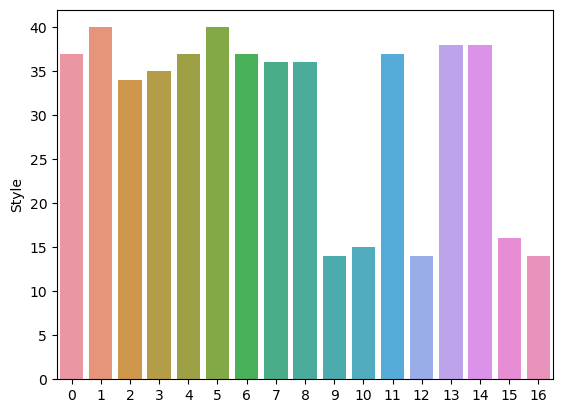

In [265]:
style = train_df["Style"].value_counts().sort_index()
sns.barplot(x=style.index, y=style)

The most popular style is 1 and 5

In [266]:
fig = px.treemap(train_df, path=["Style"], values="ID", title="Beer style at a glance")
fig.show()

In [298]:
num_cols = get_nummerical_cols(train_df, "Style", "ID")
cat_cols = get_categorical_cols(train_df)

In [314]:
cat_cols

['Name', 'Brewery', 'Beer Name (Full)', 'Description']

In [299]:
num_cols

['ABV',
 'Min IBU',
 'Max IBU',
 'Astringency',
 'Body',
 'Alcohol',
 'Bitter',
 'Sweet',
 'Sour',
 'Salty',
 'Fruits',
 'Hoppy',
 'Spices',
 'Malty',
 'review_aroma',
 'review_appearance',
 'review_palate',
 'review_taste',
 'review_overall',
 'number_of_reviews']

### Distribution for Each variables

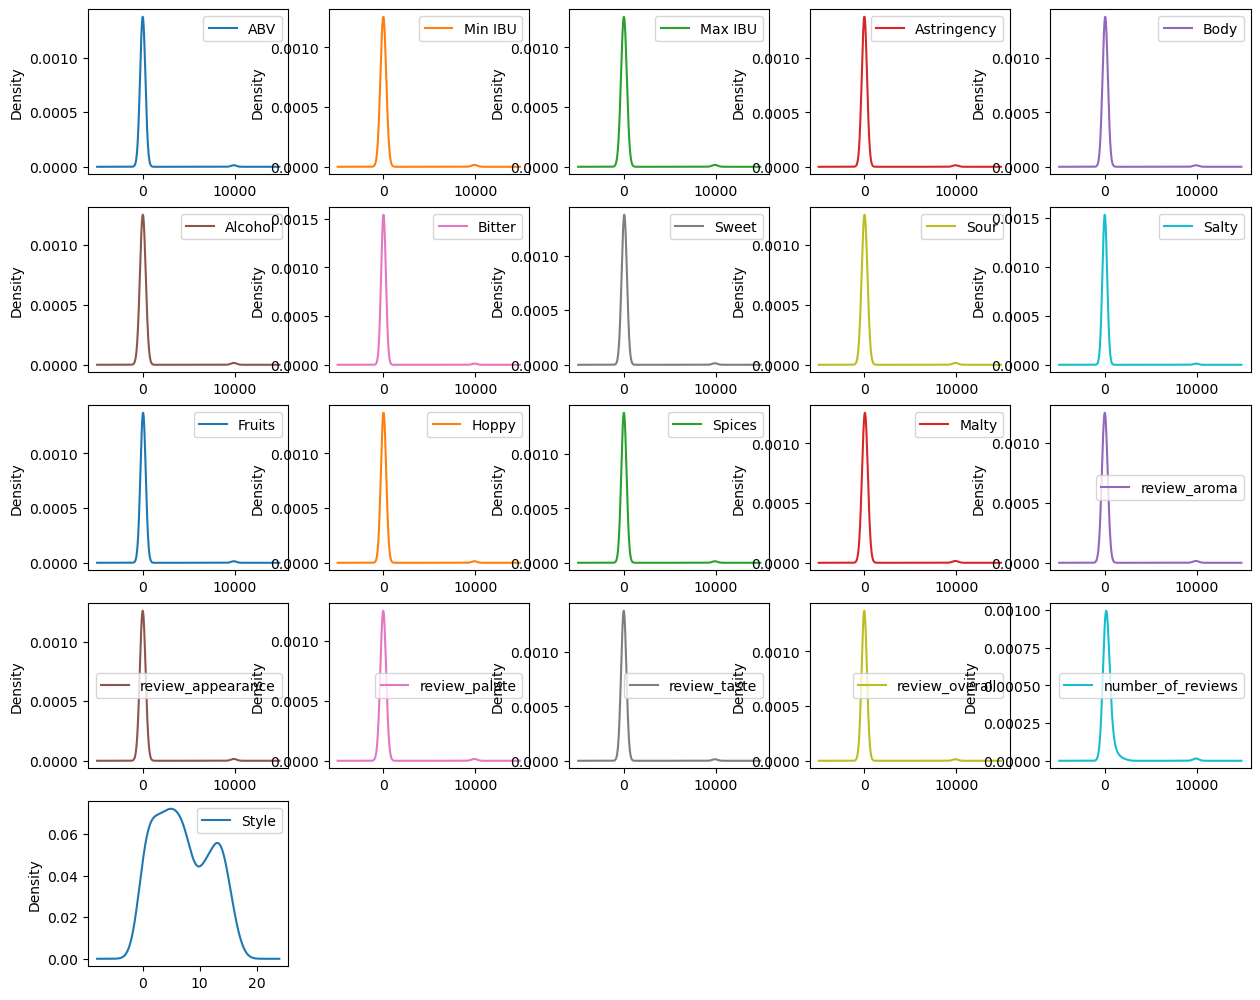

In [285]:
train_df[num_cols].plot(
    kind="density",
    layout=(6, 5),
    subplots=True,
    sharex=False,
    sharey=False,
    figsize=(15, 15),
)
plt.show()

### Correlations

In [286]:
def plot_correlation_heatmap(df: pd.core.frame.DataFrame, title: str) -> None:
    corr = df.corr()
    fig, axes = plt.subplots(figsize=(20, 10))
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(corr, mask=mask, linewidths=0.5, annot=True)
    plt.title(title)
    plt.show()

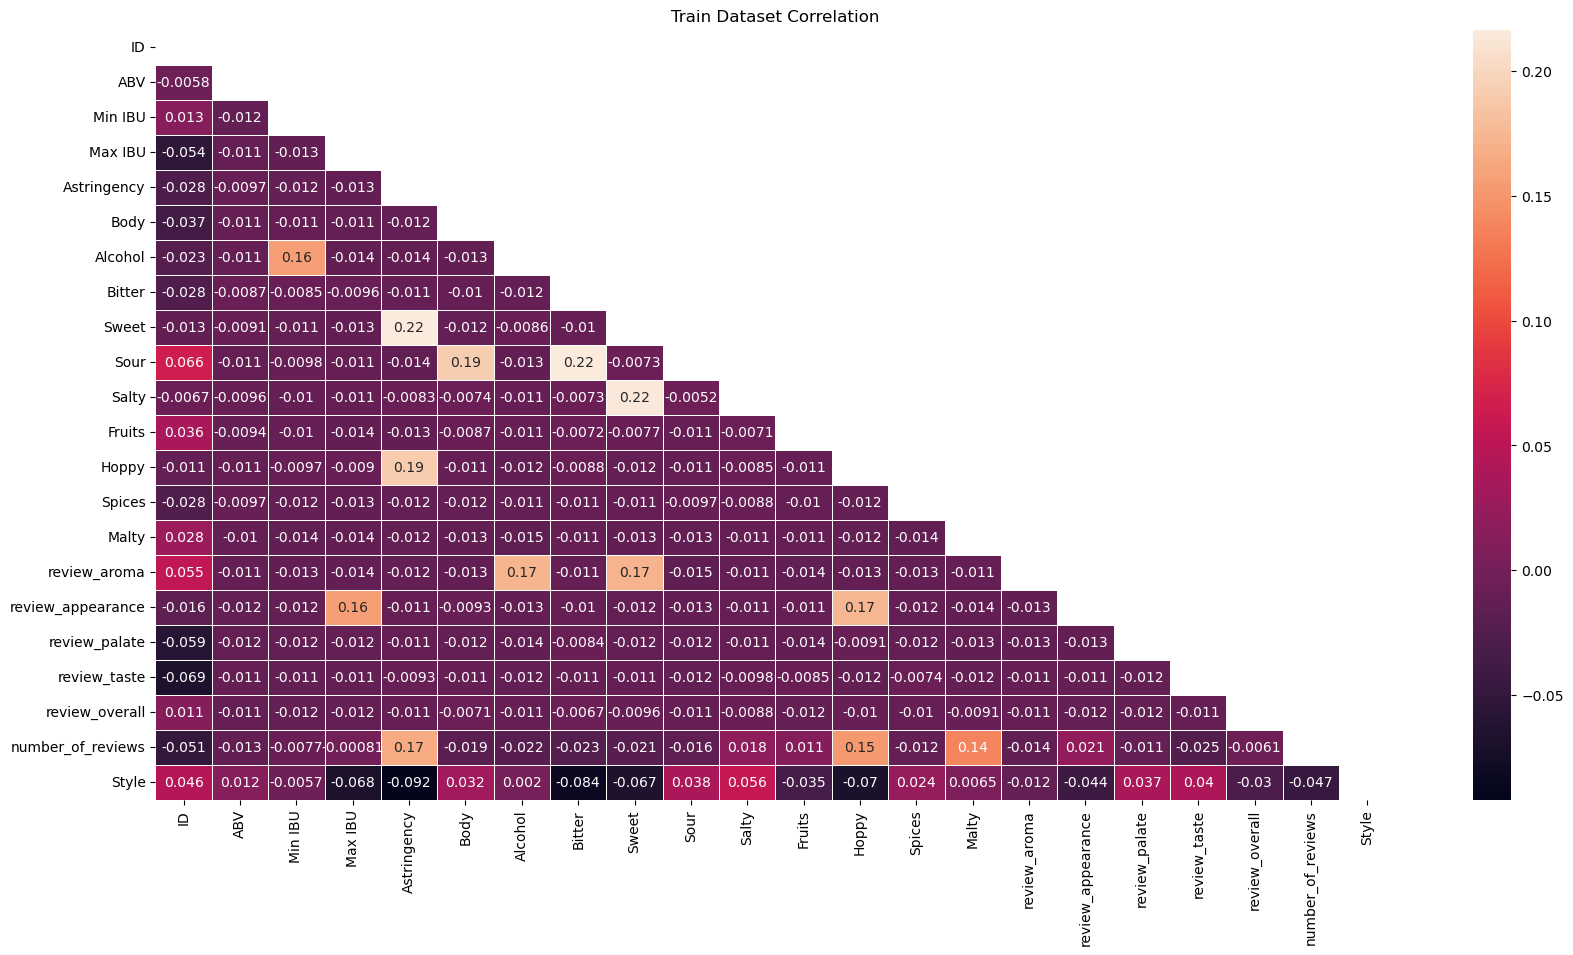

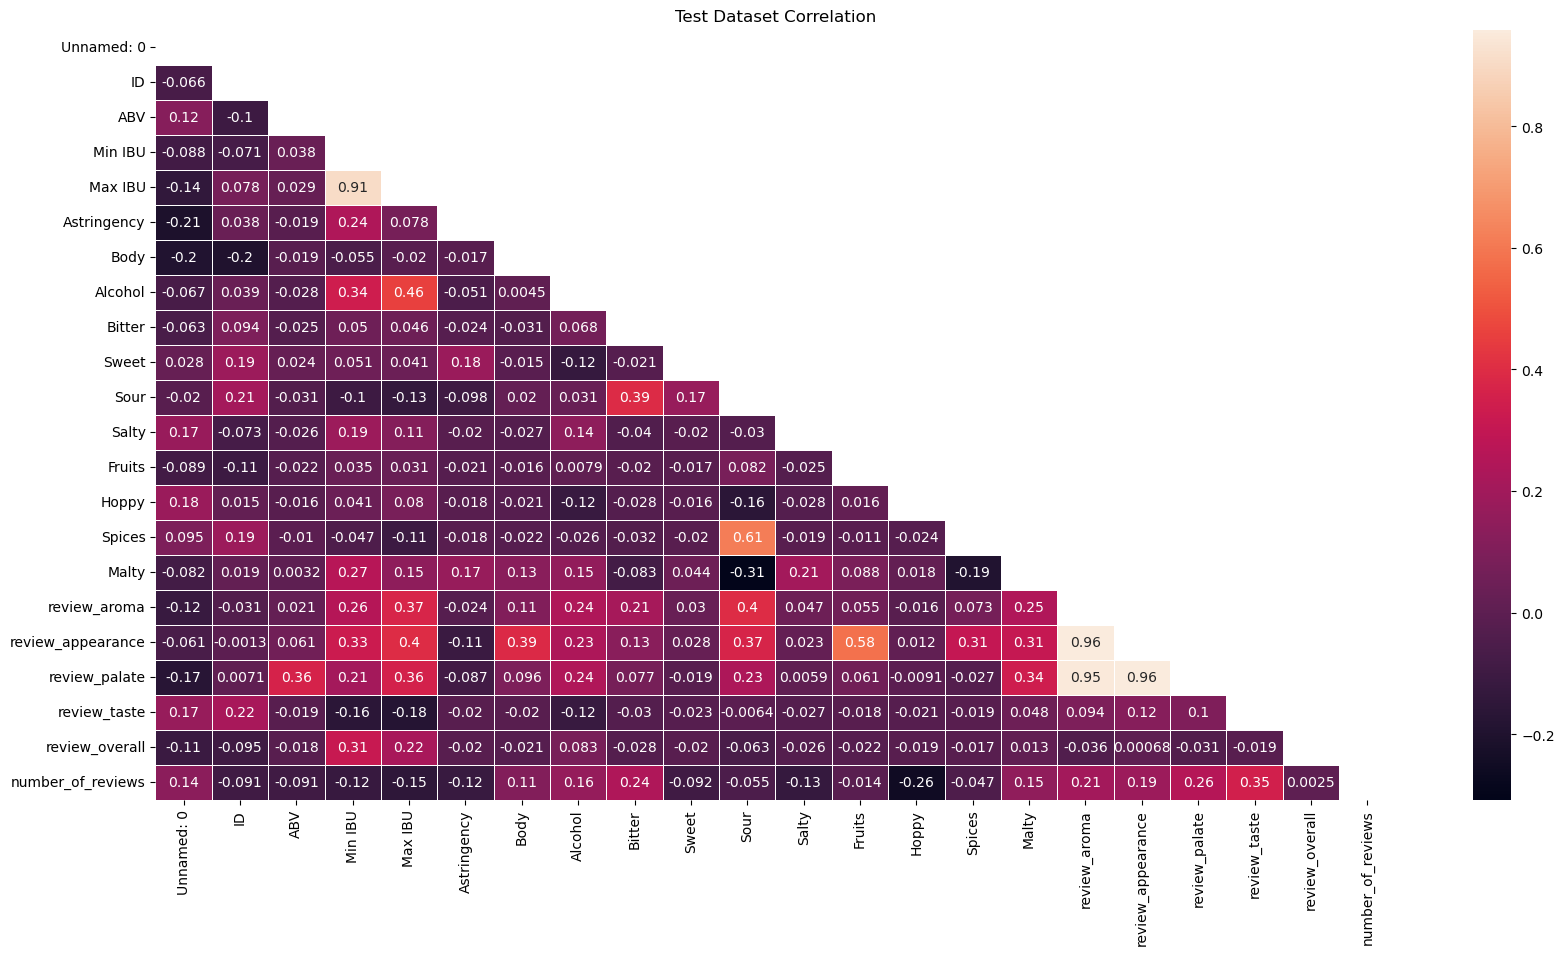

In [270]:
plot_correlation_heatmap(train_df, "Train Dataset Correlation")
plot_correlation_heatmap(test_df, "Test Dataset Correlation")

### Number of Reviews for Each Styles

In [271]:
train_df.groupby("Style")["number_of_reviews"].mean().to_frame()

,number_of_reviews
Style,
0,406.742857
1,287.894737
2,397.937500
3,405.147059
4,960.694444
5,230.289474
6,390.944444
7,521.805556
8,566.750000


## Modelling and Evaluation

We will use F1 as an evaluation metrics. We're using 'macro' option as it will calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.

In [302]:
X = train_df[num_cols]
y = train_df["Style"]

In [357]:
X_train, X_eval, y_train, y_eval = train_test_split(
    X, y, test_size=0.2, random_state=1004
)

In [341]:
d_train = lgb.Dataset(X_train, label=y_train)

In [370]:
params_lgb = dict(
    learning_rate=0.03,
    boosting_type="gbdt",  # GradientBoostingDecisionTree
    objective="multiclass",  # Multi-class target feature
    metric="multi_logloss",  # metric for multi-class
    max_depth=7,
    num_class=17,
    verbose=-1,
)

In [ ]:
lgb_model = lgb.train(params, d_train, 1000)

In [368]:
y_eval_pred = lgb_model.predict(X_eval)

In [316]:
def evaluate(y, y_pred):
    return f1_score(y, np.argmax(y_pred, axis=-1), average="macro")

In [369]:
evaluate(y_eval, y_eval_pred)

0.8920948616600791

In [310]:
X_test = test_df[num_cols]

In [311]:
y_test_pred = lgb_model.predict(X_test)

In [312]:
submission = submission_df.copy()
submission_df["Style"] = np.argmax(y_test_pred, axis=-1)
submission_df.to_csv("submission.csv", index=False)

In [313]:
submission_df.head()

,ID,Style
0,334,9
1,218,13
2,446,5
3,598,8
4,502,0
